# ML Homework1
#### 0756021 張逸群

## Input Parameters

In [1]:
INPUT_FILENAME = 'sample_input.txt'
MY_FAKE_DATA = True
NUMBER_POLYNOMIAL_BASES = 10
LSE_LAMBDA = 5

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Input Data

In [3]:
def load_input(filename):
    if MY_FAKE_DATA:
        Xs = np.random.rand(200) * 12. - 6.
        ys = np.sin(Xs) + np.random.rand(200)*0.5
    else:
        Xs, ys = list(), list()
        with open(filename, 'r') as f:
            for line in f:
                numbers = line.strip().split(',')
                Xs.append(float(numbers[0]))
                ys.append(float(numbers[1]))

    return np.array(Xs), np.array(ys)

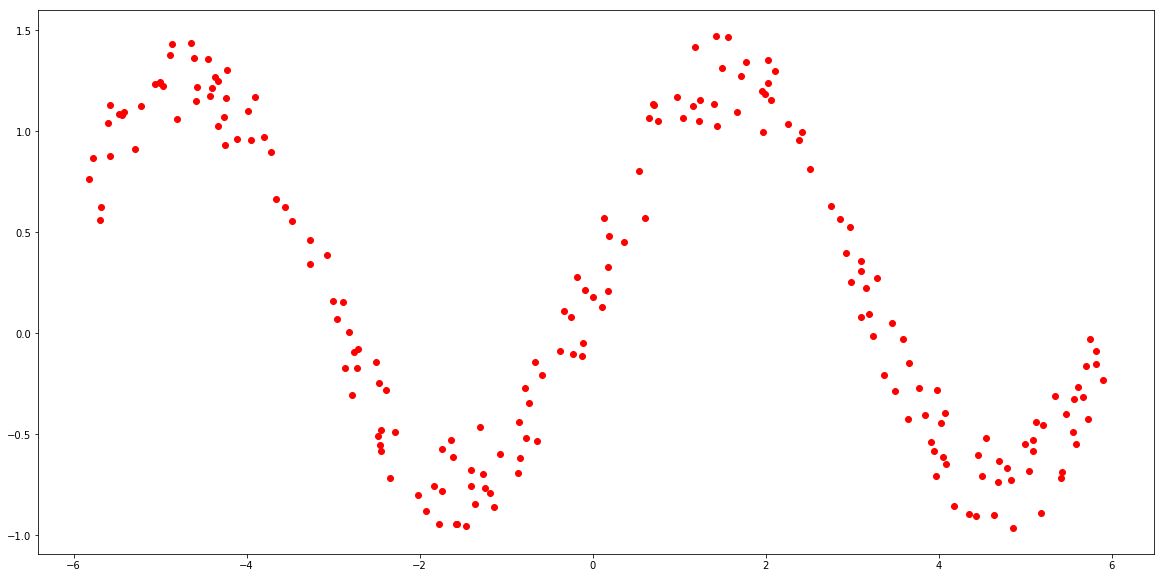

In [4]:
Xs, ys = load_input(INPUT_FILENAME)

plt.figure(figsize=(20, 10))
plt.scatter(Xs, ys, color='r')
plt.show()

## LSE

In [5]:
def get_poly_phi_matrix(Xs, number_bases):
    phi = np.zeros([Xs.shape[0], number_bases]) # (number of points, number of bases)
    for j in range(phi.shape[0]):
        for i in range(phi.shape[1]):
            phi[j][i] = np.power(Xs[j], i)
    return phi

In [6]:
def inverse(matrix):
    def LU_decomposition(matrix):
        def Li_inverse(L, index_column):
            rtn = np.identity(L.shape[0])
            for j in range(index_column+1, L.shape[0]):
                rtn[j][index_column] = -L[j][index_column]
            return rtn

        # LU decomposition
        n_dimension = matrix.shape[0]
        L = np.identity(n_dimension)
        U = matrix.copy()

        for i in range(n_dimension-1):
            Li = np.identity(n_dimension)
            for j in range(i+1, n_dimension):
                Li[j][i] = -1 * U[j][i] / U[i][i]

            U = Li @ U
            L = L @ Li_inverse(Li, i)
        return L, U
    
    def row_operation(m, row_origin, row_dest, mag):
        m[row_dest] = m[row_dest] + m[row_origin] * mag
        return m
    
    def L_inverse(L):
        n_dimension = L.shape[0]
        inv = np.identity(n_dimension)
        
        for i in range(n_dimension-1):
            for j in range(i+1, n_dimension):
                inv = row_operation(inv, i, j, -L[j][i] / L[i][i])
        return inv
    
    def U_inverse(U):
        n_dimension = U.shape[0]
        inv = np.identity(n_dimension)
        
        K = np.identity(n_dimension)
        K_inv = np.identity(n_dimension)
        for i in range(n_dimension):
            K[i][i] = 1 / U[i][i]
        U = K @ U
        
        # change signs of the off-diagonal elements
        for i in range(n_dimension-1, 0, -1):
            for j in range(i):
                inv = row_operation(inv, i, j, -U[j][i] / U[i][i])
        return inv @ K
    
    L, U = LU_decomposition(matrix)
    return U_inverse(U) @ L_inverse(L)

test_matrix = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 18, 14], [13, 14, 15, 17]])
test_result = (inverse(test_matrix) @ test_matrix) - np.identity(4)
test_result[test_result < 0.00001] = 0 # thresholding
if test_result.any():
    print('Inverse Error!')
else:
    print('Inverse Pass!')

Inverse Pass!


In [7]:
def predict(parameters, Xs):
    Xs = np.array(Xs)
    phi = get_poly_phi_matrix(Xs, number_bases=NUMBER_POLYNOMIAL_BASES)
    return (phi @ parameters)[:, 0]

In [8]:
phi = get_poly_phi_matrix(Xs, number_bases=NUMBER_POLYNOMIAL_BASES)
b = ys[..., np.newaxis]
parameters = inverse( phi.transpose() @ phi + LSE_LAMBDA * np.identity(phi.shape[1]) ) @ phi.transpose() @ b

### Results

In [9]:
formular_string = '{:.2f} x^{}'.format(parameters[NUMBER_POLYNOMIAL_BASES-1, 0], NUMBER_POLYNOMIAL_BASES-1)
for i in range(NUMBER_POLYNOMIAL_BASES-2, -1, -1):
    formular_string += ' + {:.2f} x^{}'.format(parameters[i, 0], i)

diff = predict(parameters, Xs) - ys
total_error = (diff * diff).sum()
    
print('LSE:')
print('Fitting line:', formular_string)
print('Total error:', total_error)

LSE:
Fitting line: -0.00 x^9 + -0.00 x^8 + -0.00 x^7 + 0.00 x^6 + 0.00 x^5 + -0.00 x^4 + -0.12 x^3 + 0.02 x^2 + 0.87 x^1 + 0.21 x^0
Total error: 4.662178186907507


### Visualization

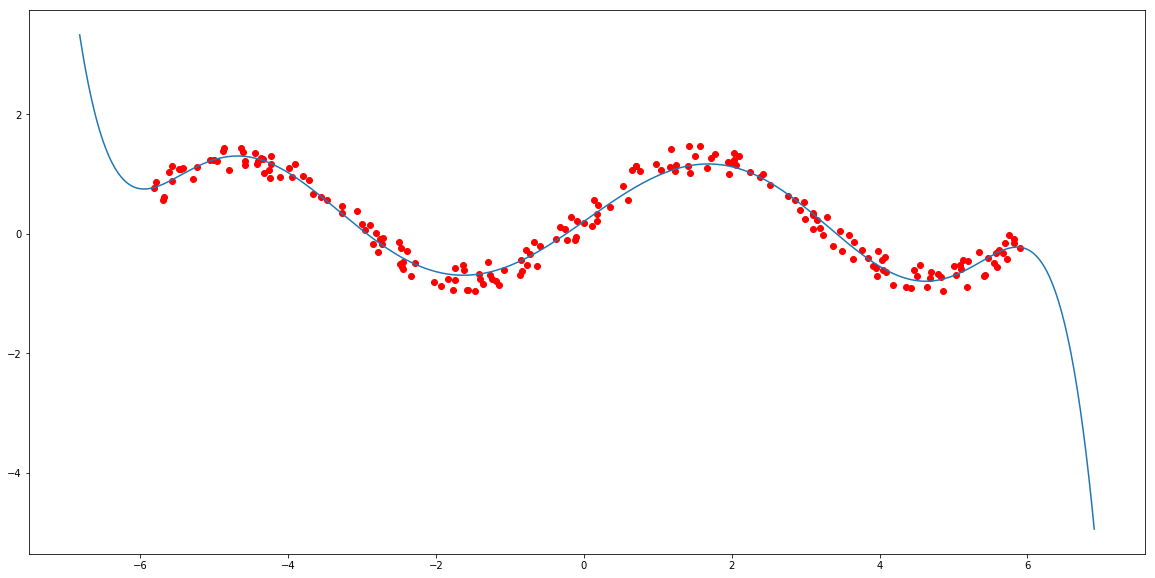

In [10]:
plt.figure(figsize=(20, 10))
plt_xs = np.arange(Xs.min()-1, Xs.max()+1, 0.01)
plt.plot(plt_xs, predict(parameters, plt_xs))
plt.scatter(Xs, ys, color='r')
plt.show()

## Newton's Method

\begin{equation*}
\overrightarrow{x_1} =  \overrightarrow{x_0} - (A^TA)^{-1}A^TA \overrightarrow{x_0} + (A^TA)^{-1}A^T \overrightarrow{b}  
\end{equation*}

In [11]:
phi = get_poly_phi_matrix(Xs, number_bases=NUMBER_POLYNOMIAL_BASES)
b = ys[..., np.newaxis]
# randomly choose one parameter
parameters = np.random.rand(NUMBER_POLYNOMIAL_BASES)
parameters = parameters - inverse(phi.transpose() @ phi) @ phi.transpose() @ phi @ parameters + inverse(phi.transpose() @ phi) @ phi.transpose() @ b

### Result

In [12]:
formular_string = '{:.2f} x^{}'.format(parameters[NUMBER_POLYNOMIAL_BASES-1, 0], NUMBER_POLYNOMIAL_BASES-1)
for i in range(NUMBER_POLYNOMIAL_BASES-2, -1, -1):
    formular_string += ' + {:.2f} x^{}'.format(parameters[i, 0], i)

diff = predict(parameters, Xs) - ys
total_error = (diff * diff).sum()
    
print('Newton\' Method:')
print('Fitting line:', formular_string)
print('Total error:', total_error)

Newton' Method:
Fitting line: 0.00 x^9 + -0.00 x^8 + -0.00 x^7 + 0.00 x^6 + 0.01 x^5 + -0.00 x^4 + -0.17 x^3 + 0.00 x^2 + 1.04 x^1 + 0.25 x^0
Total error: 11.094969646919084


### Visualization

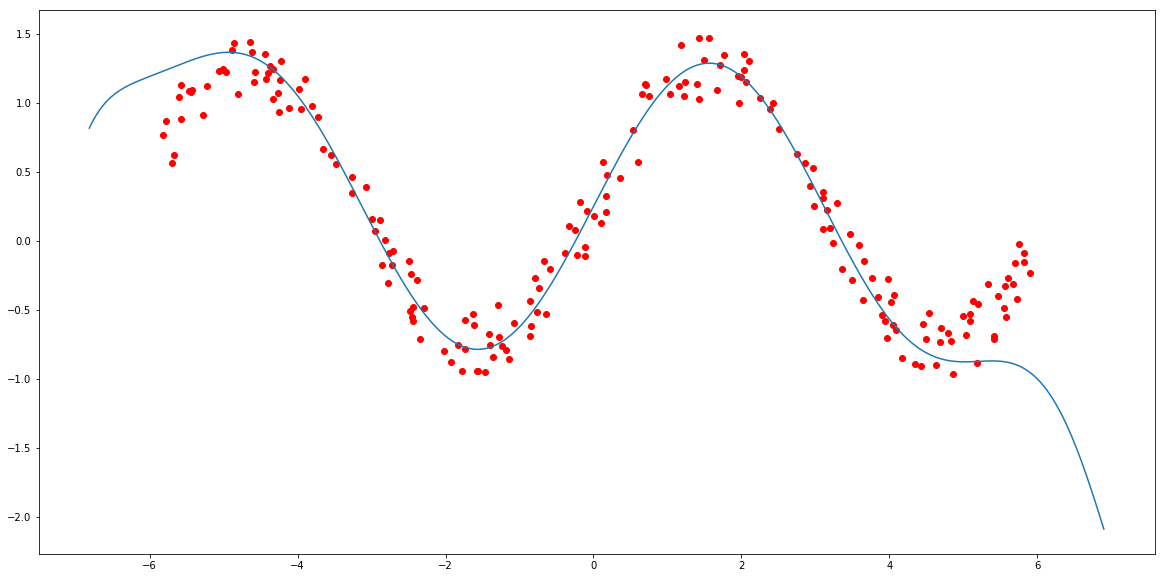

In [13]:
plt.figure(figsize=(20, 10))
plt_xs = np.arange(Xs.min()-1, Xs.max()+1, 0.01)
plt.plot(plt_xs, predict(parameters, plt_xs))
plt.scatter(Xs, ys, color='r')
plt.show()